In [2]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt

from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np

In [3]:
cs_graph = Graph()
truth_graph = Graph()

In [4]:
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=True)
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
0 in the articles graph,
0 in the categories graph,
0 in the topics graph.


In [5]:
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True) 

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
50341 in the articles graph,
6524 in the categories graph,
208 in the topics graph.


In [6]:
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
57558 in the articles graph,
6925 in the categories graph,
208 in the topics graph.


In [7]:
truth_graph.update_graph("data/links.tsv", mode='g', verbose=True)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
119754 in the articles graph,
8590 in the categories graph,
210 in the topics graph.


In [8]:
def vertices_to_df(graph, level):
    assert level in graph.authorized_levels
    _, verteces = graph.levels_map[level]
    header =["Topic", "Category", "degree", "out_degree", "in_degree", "total_weight" ,"total_weight_out", "total_weight_in","average_weight_per_edge", "average_weight_out", "average_weight_in"]  
    if level == "categories":
        header.remove("Category")
        header.append("nb_articles")
    if level == "topics":
        header.remove("Topic")
        header.remove("Category")
        header.append("nb_categories")
        header.append("nb_articles")
    
    df = pd.DataFrame(columns=header)
    for vertex in verteces.values():
        nb_unique_outgoing_edges = vertex.get_nb_different_out_neighbours()
        nb_unique_incoming_edges = vertex.get_nb_different_in_neighbours()
        nb_unique_edges = nb_unique_outgoing_edges + nb_unique_incoming_edges
        
        if (nb_unique_edges != 0) :
            total_weight_out = vertex.get_total_out_weight()
            total_weight_in = vertex.get_total_in_weight()
            total_weight = total_weight_out + total_weight_in
            average_weight_out = round(total_weight_out/nb_unique_outgoing_edges, 2) if nb_unique_outgoing_edges != 0 else 0
            average_weight_in = round(total_weight_in/nb_unique_incoming_edges,2) if nb_unique_incoming_edges != 0 else 0
            average_weight_per_edge = round(total_weight/nb_unique_edges, 2)

            if level == "articles":
                df.loc[vertex.title] = [vertex.topic, vertex.category, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in]
                df["Topic"].astype("category")
                df["Category"].astype("category")
            elif level == "categories":
                df.loc[vertex.title]= [vertex.topic, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_articles()]
                df["Topic"].astype("category")
            else:
                df.loc[vertex.title]= [nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_categories(), vertex.get_nb_different_articles()]
    return df

In [9]:
df_articles_cs = vertices_to_df(cs_graph, level="articles")
df_categrories_cs = vertices_to_df(cs_graph, level="categories")
df_topics_cs = vertices_to_df(cs_graph, level="topics")

In [10]:
df_articles_cs.head()

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
%C3%85land,Geography,European_Countries,4,3,1,7,3,4,1.75,1.00,4.00
%C3%89douard_Manet,People,Artists,9,6,3,13,6,7,1.44,1.00,2.33
%C3%89ire,Geography,European_Countries,5,3,2,16,5,11,3.20,1.67,5.50
%E2%82%AC2_commemorative_coins,Business_Studies,Currency,1,1,0,1,1,0,1.00,1.00,0.00
10th_century,History,General_history,52,21,31,246,125,121,4.73,5.95,3.90


In [11]:
dict_links = {}
prev_article = ""
with open('data/links.tsv') as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for j , line in enumerate(tsv_file):
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else : 
                    if line[0] != prev_article:
                        i= 1 
                        #print('new article : ', line[0])
       
                    topic1 = truth_graph.get_topic_of_article(line[0])
                    topic2 = truth_graph.get_topic_of_article(line[1])
                    if topic1 == None or topic2 == None:
                         dict_links[j] = [line[0],line[1],i]
                    else:
                        dict_links[j] = [line[0],line[1],i]
                    i += 1
                    prev_article = line[0]

In [12]:
links_df = pd.DataFrame.from_dict(dict_links, orient='index', columns=['article_from', 'article_to', 'position'])

In [13]:
links_df.head()

,article_from,article_to,position
12,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,1
13,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,2
14,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,3
15,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,4
16,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,5


In [14]:
links_df['weight'] = links_df.apply(lambda row: cs_graph.get_weight_of_link(row['article_from'],row['article_to']),axis=1)

In [15]:
#filter weight = 0 (unexplored links in the article)
links_df['nb_links'] = links_df.groupby('article_from')['article_from'].transform('count')
links_df = links_df[links_df['weight'] != 0].drop(columns=['weight'])

In [16]:
links_df['nb_explored_links'] = links_df.groupby('article_from')['article_from'].transform('count')
links_df['proportion_explored'] = links_df['nb_explored_links']/links_df['nb_links']
#drop duplicates
links_df = links_df.drop_duplicates(subset=['article_from'])
links_df.head()

,article_from,article_to,position,nb_links,nb_explored_links,proportion_explored
24,%C3%85land,Baltic_Sea,2,19,3,0.157895
44,%C3%89douard_Manet,Claude_Monet,3,20,6,0.300000
62,%C3%89ire,Canada,1,8,3,0.375000
102,%E2%82%AC2_commemorative_coins,Ireland,23,47,1,0.021277
127,10th_century,11th_century,1,26,21,0.807692


C:\Users\youss\AppData\Local\Temp\ipykernel_4200\645204640.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(links_df['nb_links'], bins=100, kde=True, rug=False)


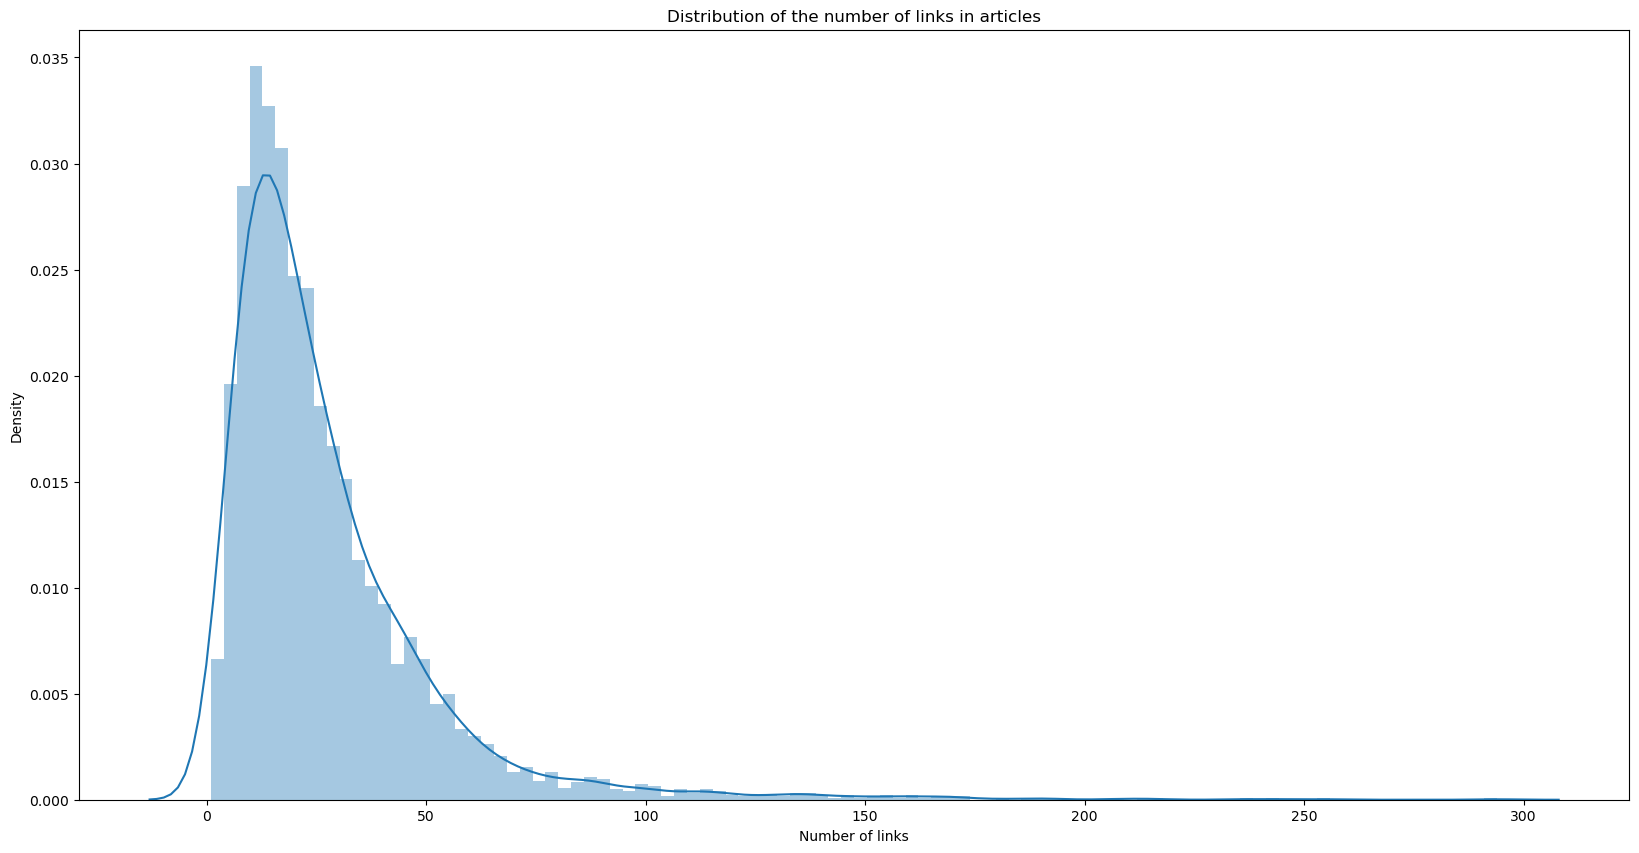

In [17]:
plt.figure(figsize=(20,10))
sns.distplot(links_df['nb_links'], bins=100, kde=True, rug=False)
plt.title("Distribution of the number of links in articles")
plt.xlabel("Number of links")
plt.ylabel("Density")
plt.show()

Observation: The number of links distribution in articles is skewed to the right. The majority of articles have less than 100 links.
A possible approach to solve this is to divide the articles into multiple groups.

In [19]:
#plot the avegrage of nb_explored_links and proportion_explored for each nb_links
# links_df['nb_links'] = links_df['nb_links'].astype(int)
# links_df['nb_explored_links'] = links_df['nb_explored_links'].astype(int)
# links_df['proportion_explored'] = links_df['proportion_explored'].astype(float)
# links_df = links_df.groupby('nb_links').mean()
# links_df = links_df.reset_index()
#filter nb_links > 75
links_df = links_df[links_df['nb_links'] <= 100]
# links_df

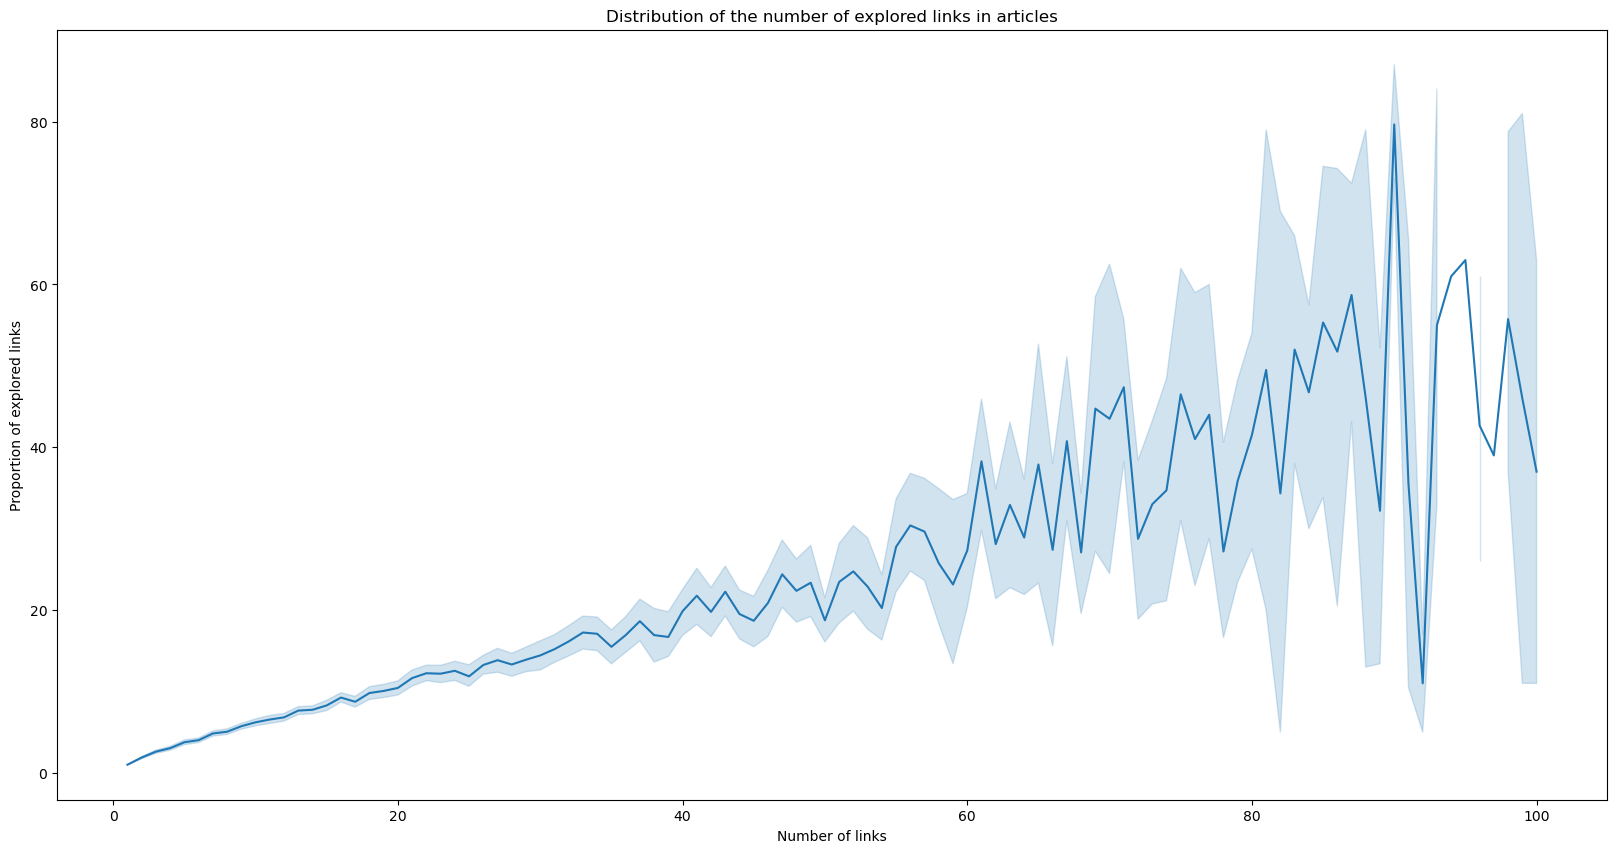

In [21]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=links_df, x="nb_links", y="nb_explored_links")
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()

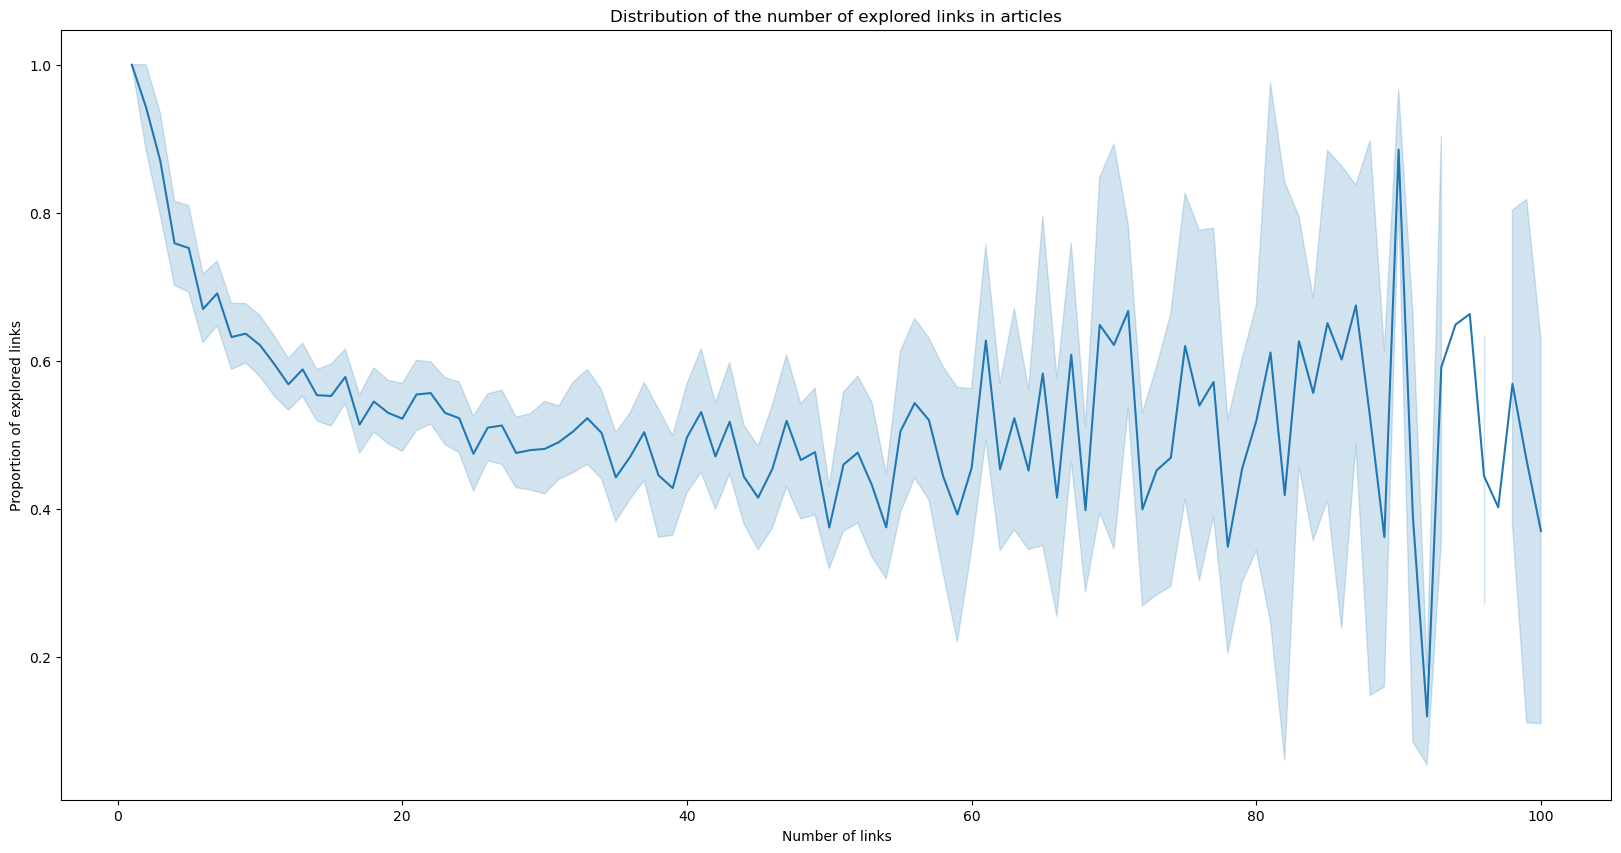

In [22]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=links_df, x="nb_links", y="proportion_explored")
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()



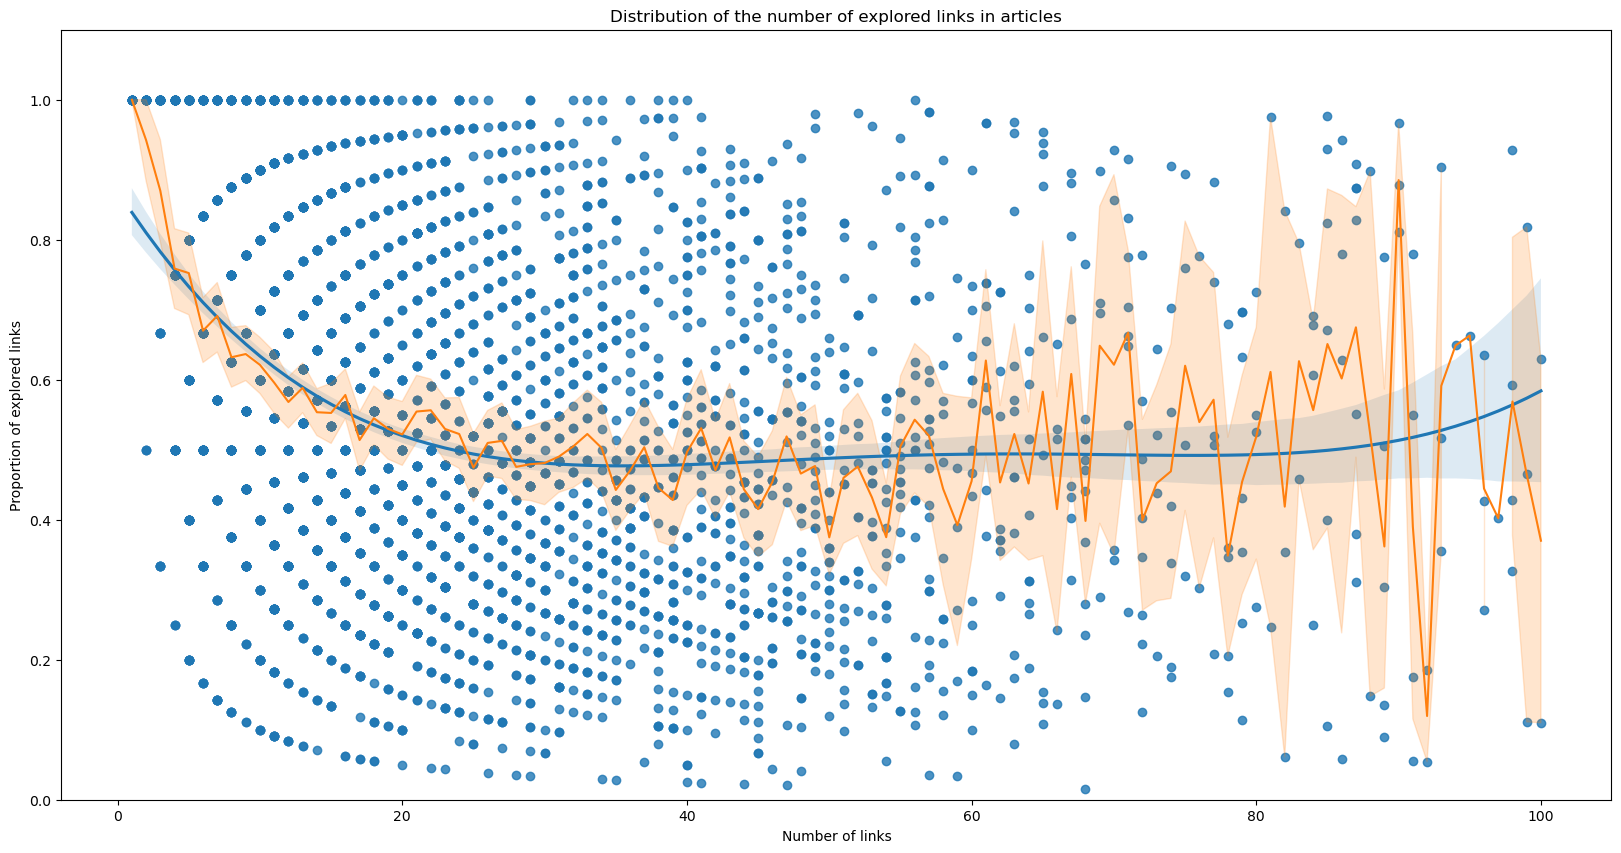

In [23]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
#scale the y axis to 0-1
plt.ylim(0,1.1)

sns.regplot(data=links_df, x="nb_links", y="proportion_explored", order = 4, scatter=True)
sns.lineplot(data=links_df, x="nb_links", y="proportion_explored", errorbar=('ci',95))
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()


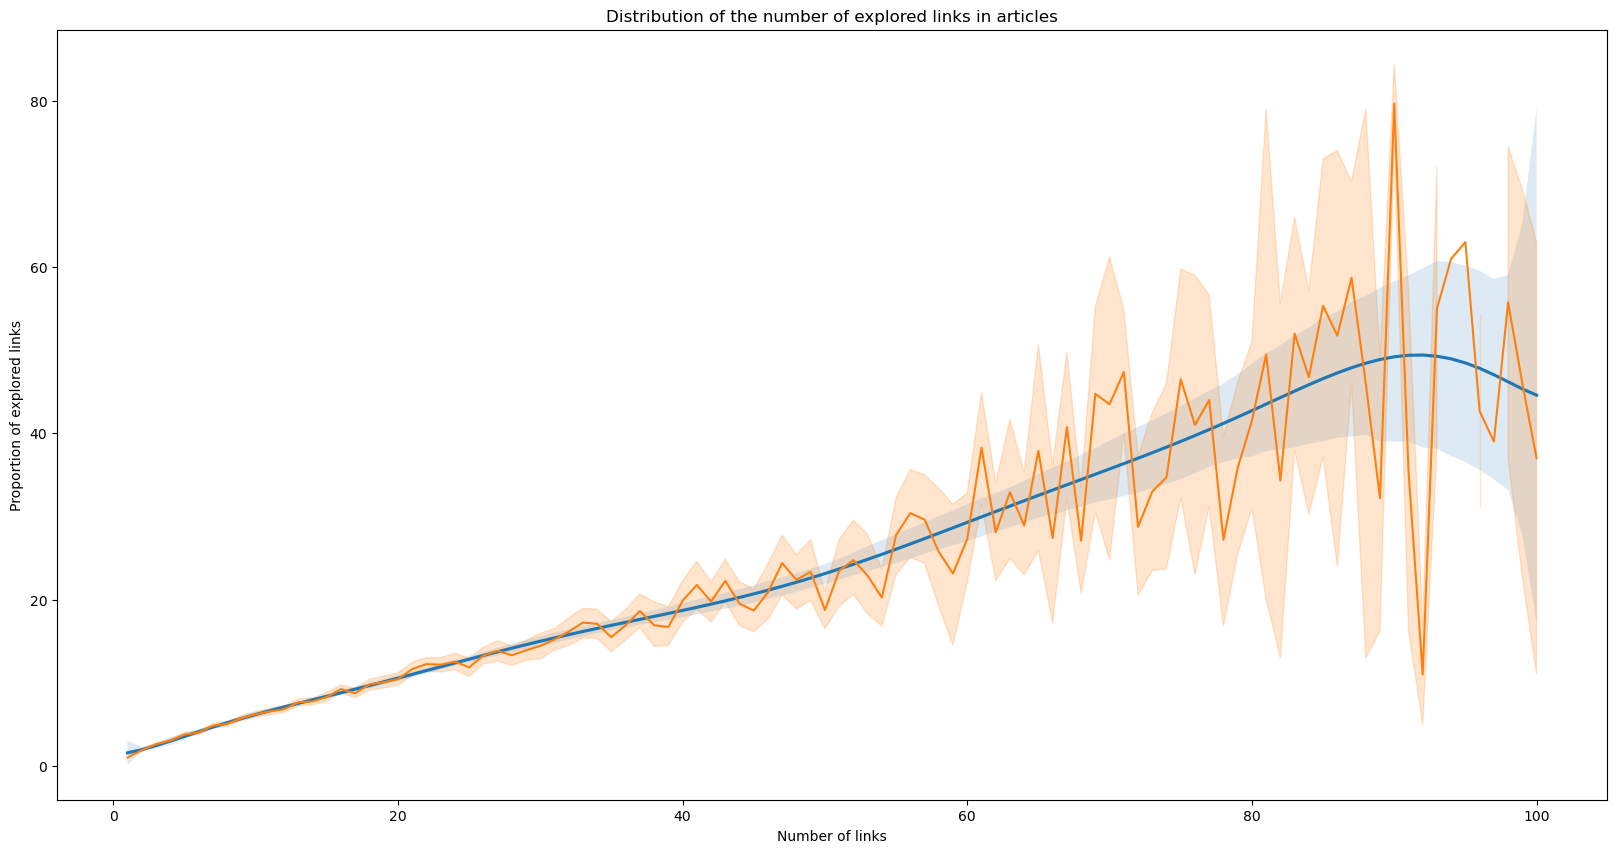

In [24]:
plt.figure(figsize=(20,10))
sns.regplot(data=links_df, x="nb_links", y="nb_explored_links", order = 10, scatter=False)
sns.lineplot(data=links_df, x="nb_links", y="nb_explored_links", errorbar=('ci',90))
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()


In [25]:
#devide links_df into 2 groups : nb_links < 80 and nb_links > 80
links_df_1 = links_df[links_df['nb_links'] < 60]
links_df_2 = links_df[links_df['nb_links'] >= 60]

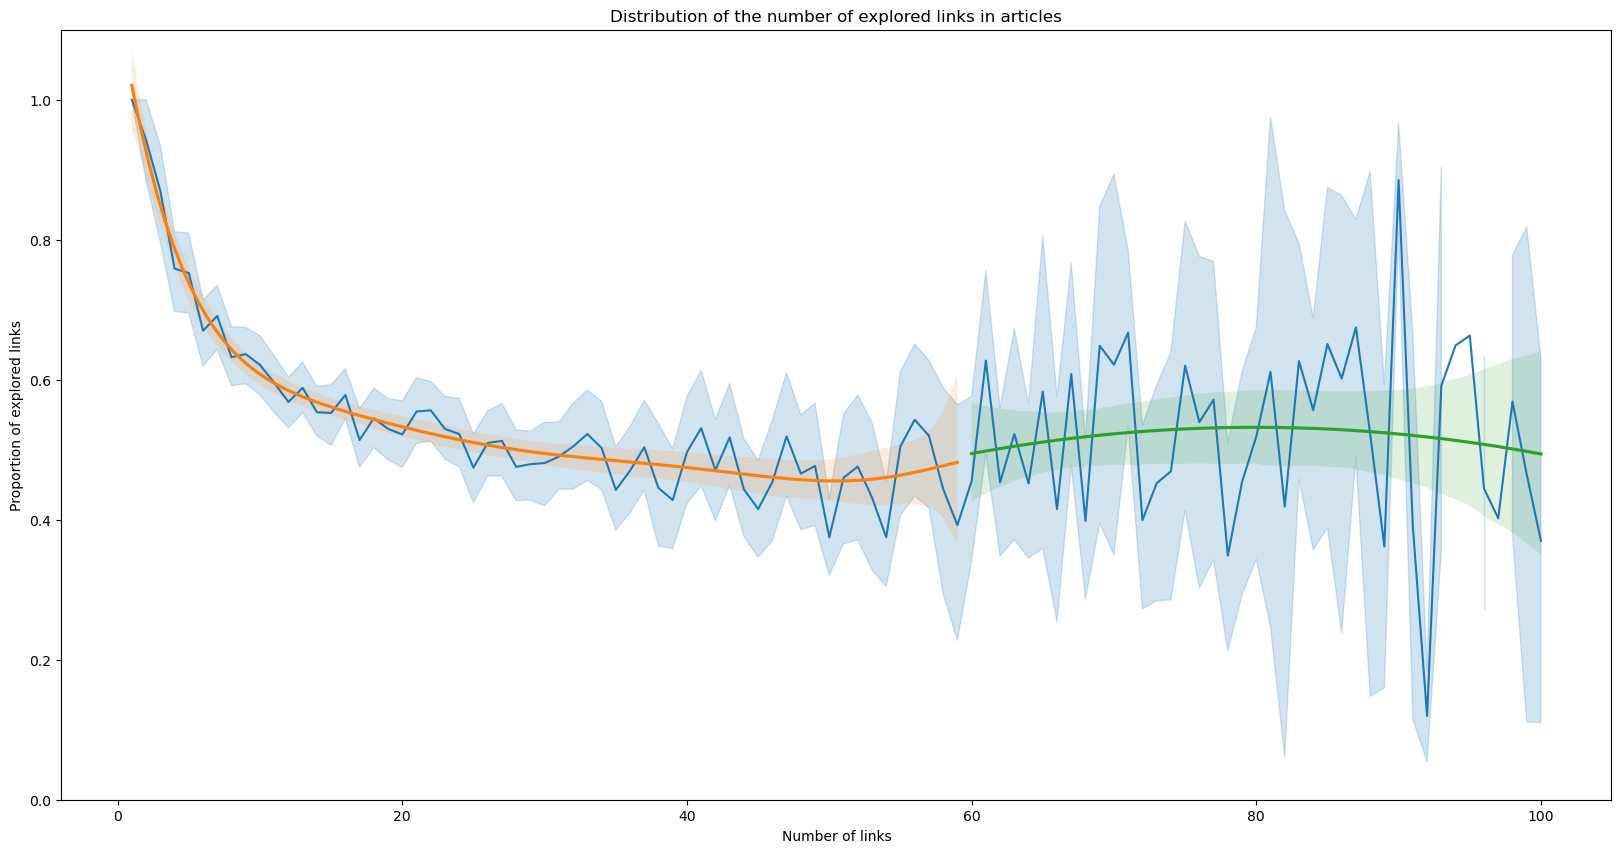

In [26]:
#plot the the nb_explored_links by nb_links for the 2 dfs in the same plot
plt.figure(figsize=(20,10))
#scale the y axis to 0-1
plt.ylim(0,1.1)
sns.lineplot(data=links_df, x="nb_links", y="proportion_explored")
sns.regplot(data=links_df_1, x="nb_links", y="proportion_explored", order = 7, scatter=False)
sns.regplot(data=links_df_2, x="nb_links", y="proportion_explored", order = 2, scatter=False)
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()


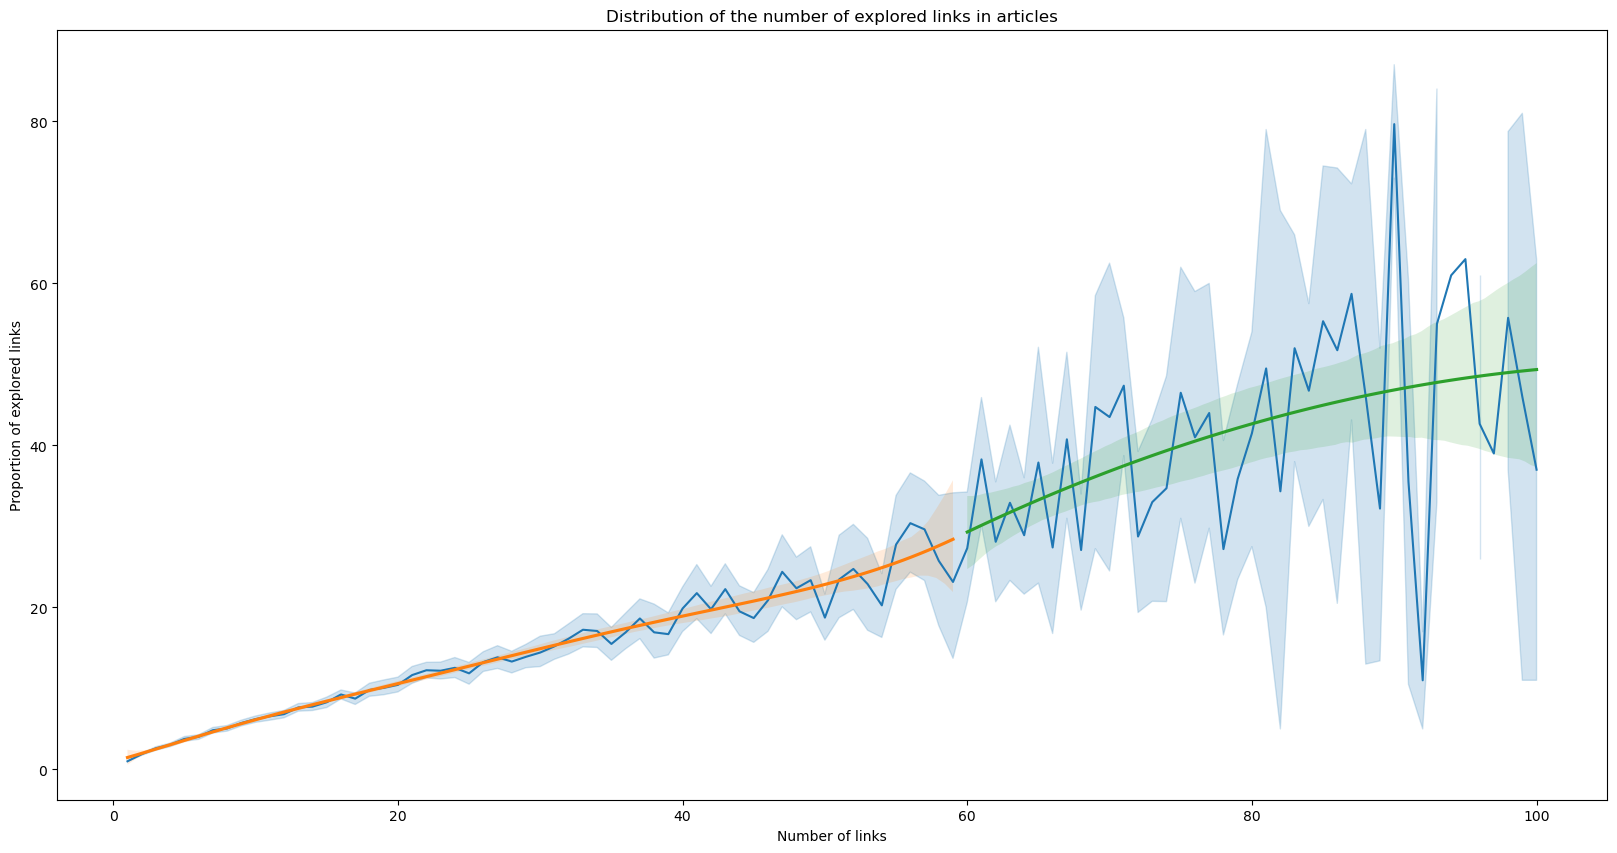

In [170]:

plt.figure(figsize=(20,10))
#scale the y axis to 0-1
sns.lineplot(data=links_df, x="nb_links", y="nb_explored_links")
sns.regplot(data=links_df_1, x="nb_links", y="nb_explored_links", order = 7, scatter=False)
sns.regplot(data=links_df_2, x="nb_links", y="nb_explored_links", order = 2, scatter=False)
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()

In [28]:
links_df['nb_links'] = links_df['nb_links'].astype(int)
links_df['nb_explored_links'] = links_df['nb_explored_links'].astype(int)
links_df['proportion_explored'] = links_df['proportion_explored'].astype(float)
links_df = links_df.groupby('nb_links').mean()
links_df = links_df.reset_index()

In [29]:
#print the min nb_links from which the proportion of explored links is < 0.5
print(links_df[links_df['proportion_explored'] < 0.5]['nb_links'].min())

25


In [19]:
dfs = []
for i in range(0,75,25):
    dfs.append(links_df[(links_df['nb_links'] >= i) & (links_df['nb_links'] < i+25)])

In [20]:
df = pd.DataFrame(columns=['nb_links', 'nb_explored_links', 'proportion_explored'])

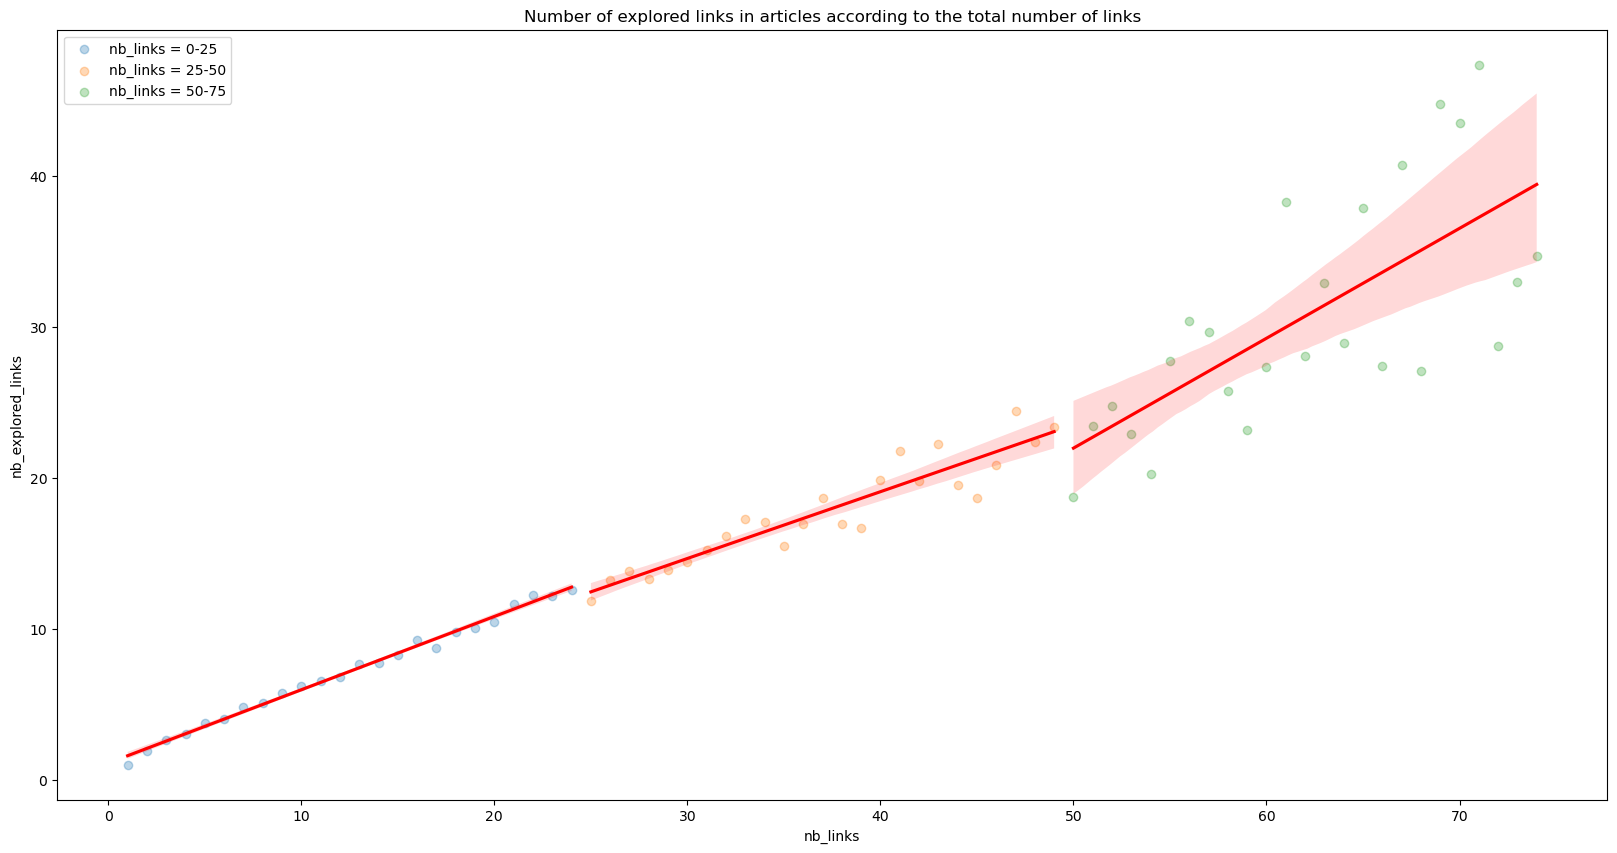

In [21]:
#plot the distribution of the nb_explored_links for each nb_links df in the same plot
#make plot more readable
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Number of explored links in articles according to the total number of links")
ax.set_xlabel("Number of links")
ax.set_ylabel("Number of explored links")

for i, df in enumerate(dfs):
    sns.regplot(x="nb_links", y="nb_explored_links", data=df, ax=ax, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.3}, label="nb_links = "+str(i*25)+"-"+str((i+1)*25))

ax.legend()
plt.show()

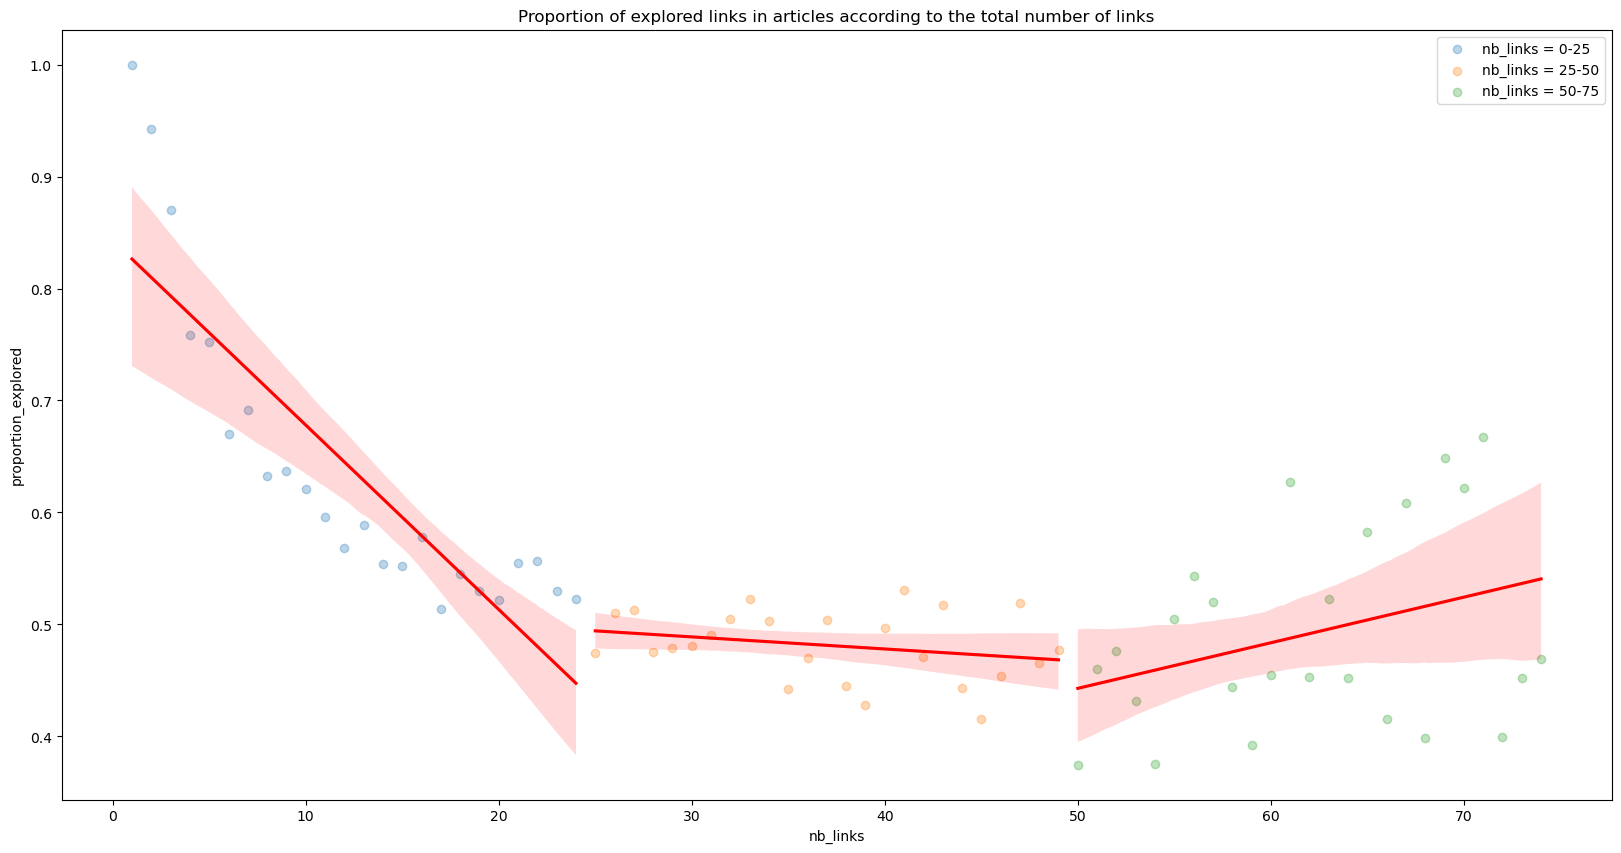

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Proportion of explored links in articles according to the total number of links")
ax.set_xlabel("Number of links")
ax.set_ylabel("Proportion of explored links")

for i, df in enumerate(dfs):
    sns.regplot(x="nb_links", y="proportion_explored", data=df, ax=ax, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.3}, label="nb_links = "+str(i*25)+"-"+str((i+1)*25))

ax.legend()
plt.show()

My theory:
The proportion of explored links in an article is decresing as the total nb of links increases until a certain point (40links) from which the proportion of explored links become constant.
This is explianed by the fact that readers tend to loose interest in articles with a number of articles that exceeds X links.


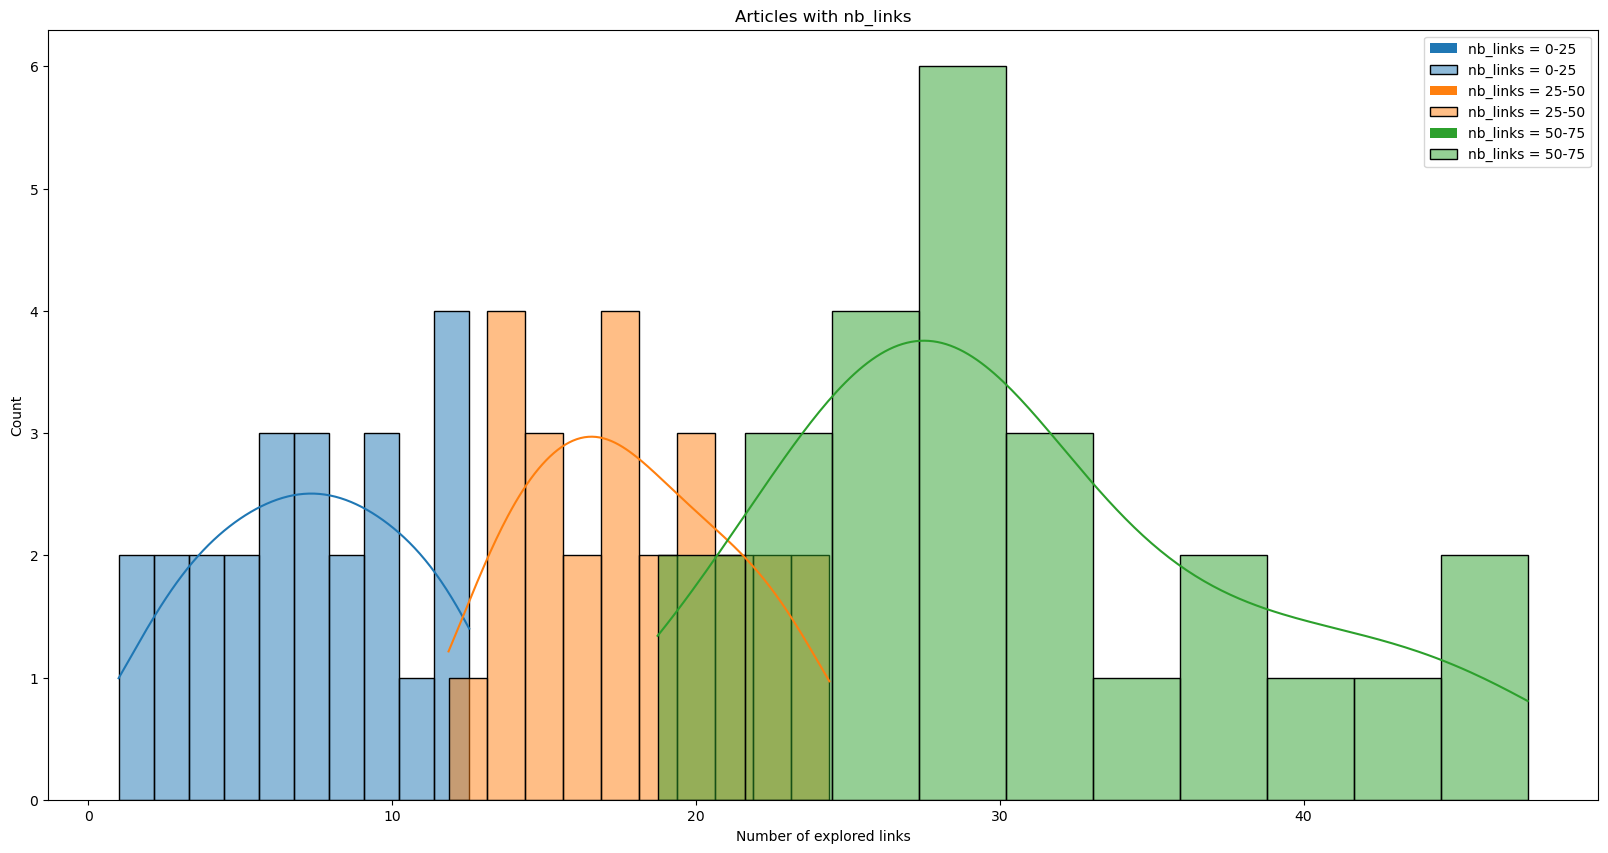

In [29]:
#plot the distribution of the nb_explored_links for each nb_links df in the same plot
fig, ax = plt.subplots(figsize=(20,10))

for i, df in enumerate(dfs):
    sns.histplot(x="nb_explored_links", data=df, ax=ax, kde=True, bins= 10, stat='count', label="nb_links = "+str(i*25)+"-"+str((i+1)*25))
    

ax.set_title("Articles with nb_links")
ax.set_xlabel("Number of explored links")
ax.set_ylabel("Count")
plt.legend()



plt.show()


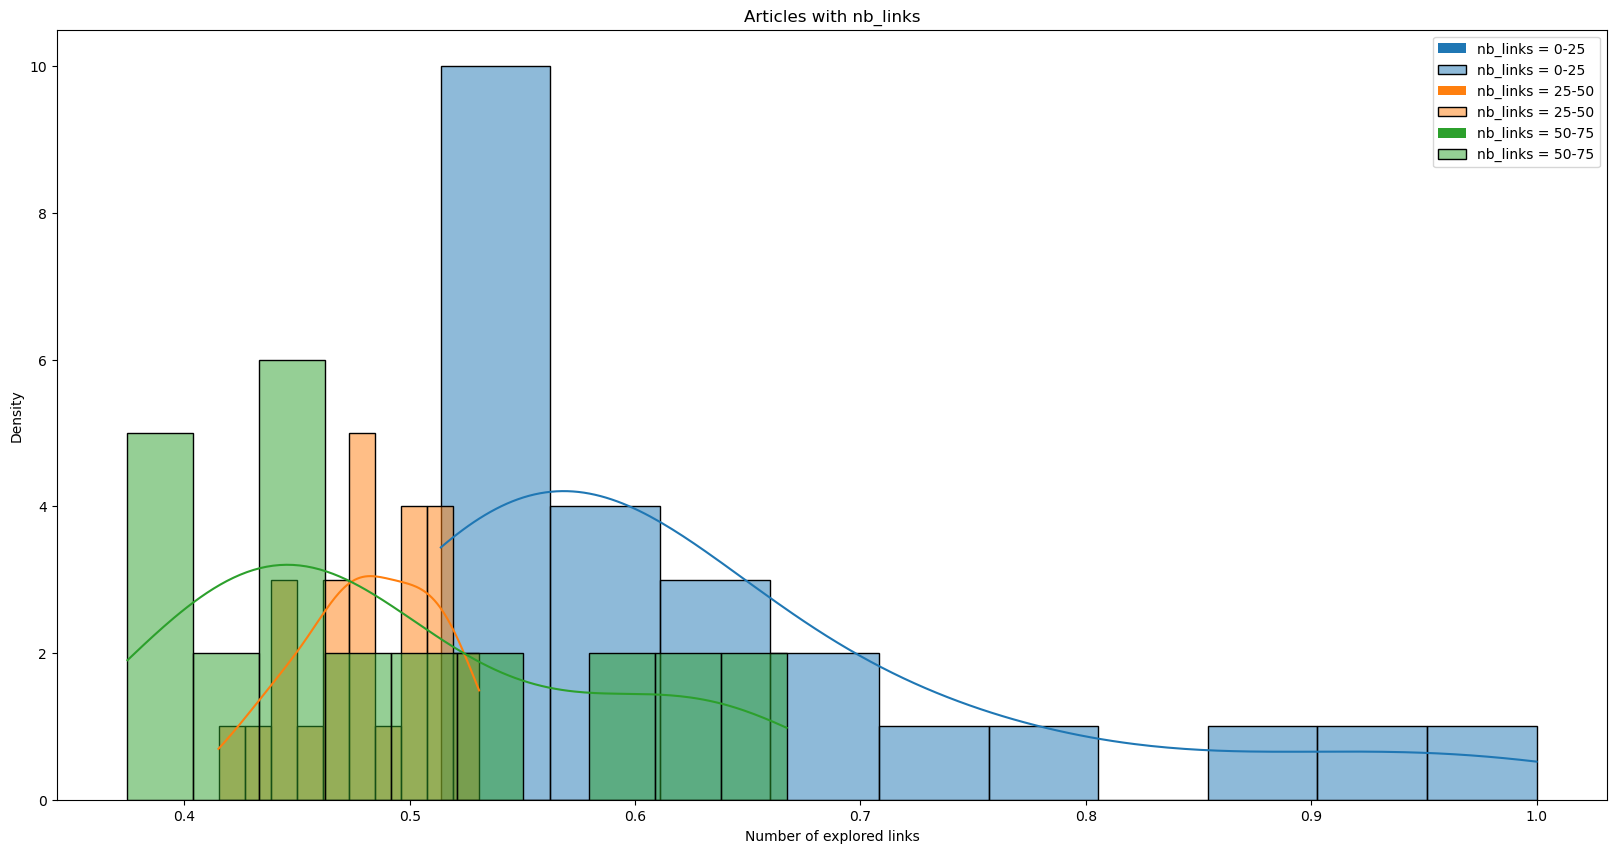

In [32]:
fig, ax = plt.subplots(figsize=(20,10))

for i, df in enumerate(dfs):
    sns.histplot(x="proportion_explored", data=df, ax=ax, kde=True, bins= 10, stat='count', label="nb_links = "+str(i*25)+"-"+str((i+1)*25),
               )
    

ax.set_title("Articles with nb_links")
ax.set_xlabel("Number of explored links")
ax.set_ylabel("Density")
plt.legend()



plt.show()

